In [4]:
import pandas as pd
import geopandas as gpd

census_tables_df = pd.read_excel("data\Metadata_2021_GCP_DataPack_R1.xlsx", skiprows=8)
census_cells_df = pd.read_excel("data\Metadata_2021_GCP_DataPack_R1.xlsx", sheet_name=1, skiprows=10)

In [5]:
census_cells_df[census_cells_df.Long.str.contains("Persons")]

,Sequential,Short,Long,DataPackfile,Profiletable,Columnheadingdescriptioninprofile
0,G1,Tot_P_M,Total_Persons_Males,G01,G01,Males
1,G2,Tot_P_F,Total_Persons_Females,G01,G01,Females
2,G3,Tot_P_P,Total_Persons_Persons,G01,G01,Persons
5,G6,Age_0_4_yr_P,Age_groups_0_4_years_Persons,G01,G01,Persons
8,G9,Age_5_14_yr_P,Age_groups_5_14_years_Persons,G01,G01,Persons
...,...,...,...,...,...,...
9401,G9402,OPDs_Other_dwelling_Tot_Psns,Occupied_private_dwellings_Other_dwelling_Tota...,G36,G36,Persons
9403,G9404,OPDs_Dwlling_structur_NS_Psns,Occupied_private_dwellings_Dwelling_structure_...,G36,G36,Persons
9405,G9406,OPDs_Tot_OPDs_Persons,Occupied_private_dwellings_Total_occupied_priv...,G36,G36,Persons
9407,G9408,Unoccupied_PDs_Psns,Unoccupied_private_dwellings_Persons,G36,G36,Persons


<AxesSubplot:>

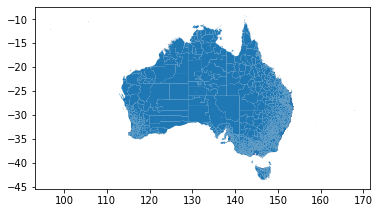

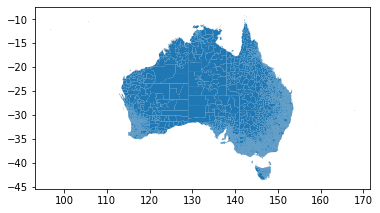

In [7]:
sa1_2021_aust_shapes_gpd = gpd.read_file("data\SA1_2021_AUST_GDA2020.shp").to_crs(crs=4326)
sa1_2021_aust_shapes_gpd.plot()
sal_2021_aust_shapes_gpd = gpd.read_file("data\SAL_2021_AUST_GDA2020.shp").to_crs(crs=4326)
sal_2021_aust_shapes_gpd.plot()

In [9]:
import osmnx as ox

def get_bounding_box_from_locations(map_zoom_locations):
    map_west, map_south, map_east, map_north = ox.geocode_to_gdf(map_zoom_locations).dissolve().iloc[0].geometry.bounds
    return {
        "north": map_north,
        "south": map_south,
        "west": map_west,
        "east": map_east
    }

get_bounding_box_from_locations(["Engadine, NSW", "Gordon, NSW", "Manly, NSW", "Merrylands, NSW"])

ProxyError: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?format=json&polygon_geojson=1&dedupe=0&limit=50&q=Engadine%2C+NSW (Caused by ProxyError('Your proxy appears to only use HTTP and not HTTPS, try changing your proxy URL to be HTTP. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#https-proxy-error-http-proxy', SSLError(SSLError(1, '[SSL: WRONG_VERSION_NUMBER] wrong version number (_ssl.c:1129)'))))

In [10]:
census_tables = {}

def load_census_table(table_name):
    if table_name in census_tables:
        return census_tables[table_name]
    
    census_table_df = pd.read_csv(f"/kaggle/input/2021-gcp-sa1-for-aus-shortheader/2021 Census GCP Statistical Area 1 for AUS/2021Census_{table_name}_AUST_SA1.csv")
    census_table_df["SA1_CODE_2021_str"] = census_table_df.SA1_CODE_2021.astype("str")
    census_table_geo_df = pd.merge(sa1_2021_aust_shapes_gpd, census_table_df, left_on="SA1_CODE21", right_on="SA1_CODE_2021_str")
    census_tables[table_name] = census_table_geo_df
    return census_table_geo_df

census_table_G03 = load_census_table("G03")
census_table_G03[["SA1_CODE21", "Total_Total"]]

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/2021-gcp-sa1-for-aus-shortheader/2021 Census GCP Statistical Area 1 for AUS/2021Census_G03_AUST_SA1.csv'

In [ ]:
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import time
import re

start_time = time.perf_counter()

def create_map(areas_df, value_column, suburbs_df = None, bounding_box = None, 
               quantile=.99, figsize=(20,20), 
               labelfontsize=15, max_labels=None, labelstroke=3,
               cmap="plasma", suburb_name_column=None,
               title=None, filename=None, ):
    
    
    # render areas
    if bounding_box is None:
        areas_on_map_df = areas_df
    else:
        areas_on_map_df = areas_df.cx[bounding_box["west"]:bounding_box["east"],bounding_box["south"]:bounding_box["north"]]
        
    max_colormap_value = areas_on_map_df[value_column].quantile(quantile)
        
    ax = areas_on_map_df.plot(value_column, figsize=figsize, 
            legend=True, cmap=cmap, vmax=max_colormap_value)
    
    
    if suburbs_df is not None:
        if bounding_box is None:
            suburbs_on_map_df = suburbs_df
        else:
            suburbs_on_map_df = suburbs_df.cx[bounding_box["west"]:bounding_box["east"],bounding_box["south"]:bounding_box["north"]]
        
        # render suburb outlines
        suburbs_on_map_df.plot(facecolor="none", ax=ax, lw=1.5, edgecolor="white", alpha=.2)

        # render suburb labels
        if max_labels is None:
            suburbs_on_map_labels_df = suburbs_on_map_df
        else:
            suburbs_on_map_labels_df = suburbs_on_map_df.sample(n=max_labels)
        
        
        if suburb_name_column is not None:
            for idx, row in suburbs_on_map_labels_df.iterrows():
                suburb_name = re.sub("\(.*\)", "", row[suburb_name_column])
                ax.annotate(
                    text=suburb_name,
                    color="white",
                    xy=(row.geometry.centroid.x, row.geometry.centroid.y), 
                    horizontalalignment='center', 
                    fontsize=labelfontsize,
                    path_effects=[pe.withStroke(linewidth=labelstroke, foreground="black")]
                )

    # zoom map to specific area
    if bounding_box is not None:
        ax.set_xlim(bounding_box["west"], bounding_box["east"])
        ax.set_ylim(bounding_box["south"], bounding_box["north"])

    if title is not None:
        ax.set_title(title, fontsize=30)
    ax.axis('off')

    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')

In [ ]:
demo_suburbs = sal_2021_aust_shapes_gpd[sal_2021_aust_shapes_gpd.SAL_NAME21.isin(["Engadine", "Yarrawarrah", "Woronora Heights"])]
demo_suburbs[["SAL_CODE21", "SAL_NAME21", "SHAPE_Area"]]

In [ ]:
create_map(demo_suburbs, "AREASQKM21", suburbs_df=demo_suburbs, suburb_name_column="SAL_NAME21")

In [ ]:
pop_area_sa_df = load_census_table("G03")
pop_area_sa_df["population_density"] = pop_area_sa_df.Total_Total / pop_area_sa_df.AREASQKM21

In [ ]:
create_map(
    pop_area_sa_df, 
    "population_density",
    suburb_name_column="SAL_NAME21",
    figsize=(20,20),
    cmap="plasma",
    title="Sydney population density",
    suburbs_df=sal_2021_aust_shapes_gpd,
    bounding_box=get_bounding_box_from_locations(["Inner West", "Eastern Suburbs"]),
    filename=f"/kaggle/working/census_2021_population_density.pdf",
    max_labels=50
)

In [ ]:
def show_census_data(cell_long_name, map_zoom_locations, relative_to_total_population=False, quantile=0.99):

    cell_details_df = census_cells_df[census_cells_df.Long == cell_long_name]
    cell_details_first = cell_details_df.iloc[0]
    table_name = cell_details_first.DataPackfile
    cell_short_name = cell_details_first.Short
    column_heading_description_in_profile_first = cell_details_first.Columnheadingdescriptioninprofile
    
    census_table_geo_df = load_census_table(table_name)
    
    if relative_to_total_population:
        display_cell = cell_short_name + "_to_total_pop"
        census_table_geo_df[display_cell] = census_table_geo_df[cell_short_name] / pop_area_sa_df.Total_Total * 100
        census_table_geo_df[display_cell] = census_table_geo_df[display_cell].fillna(0)
    else:
        display_cell = cell_short_name
       
    #return census_table_geo_df
    
    title = f"{cell_long_name} - {table_name} {cell_short_name}\n{column_heading_description_in_profile_first}"
    
    if relative_to_total_population:
        title += "\n in % relative to total population"
        
    create_map(
        census_table_geo_df, 
        display_cell,
        quantile=quantile,
        suburb_name_column="SAL_NAME21",
        figsize=(30,30),
        labelfontsize=15,
        labelstroke=4,
        cmap="plasma",
        title=title,
        suburbs_df=sal_2021_aust_shapes_gpd,
        bounding_box=get_bounding_box_from_locations(map_zoom_locations),
        filename=f"/kaggle/working/census_2021_{cell_long_name}.pdf",
        max_labels=150
    )

In [ ]:
show_census_data("Median_total_family_income_weekly", ["Gordon, NSW", "Parramatta, NSW", "Manly, NSW", "Engadine, NSW"])

In [ ]:
show_census_data("PERSONS_Greece_Total", ["Gordon, NSW", "Parramatta, NSW", "Manly, NSW", "Engadine, NSW"], relative_to_total_population=True)